## This notebook was tested in Amazon SageMaker Studio on a ml.m4.instance with Python 3 kernel.

### Select Amazon S3 Bucket

We first need to specify the locations where the original data is stored and where we will store our training data and trained model artifacts. In particular, we need the following data:

``bucket`` - An S3 bucket accessible by this account.

``prefix`` - The location in the bucket where this notebook’s input and output data will be stored. 

``downloaded_data_bucket`` - An S3 bucket where data is downloaded from this link and stored.

In [431]:
import boto3
import botocore
import sagemaker
import sys

downloaded_data_bucket = "hackathon-train"
bucket = "hackathon-extract"  # Feel free to change to another bucket you have access to
prefix = "rcf-trained-income"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name
def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}"
    )

Training input/output will be stored in: s3://hackathon-extract/rcf-trained-income
Downloaded training data will be read from s3://hackathon-train


In [462]:
%%time

import pandas as pd

data_filename = "df_income_train.csv"
mean_filename = "mean_income.csv"
std_filename = "std_income.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{data_filename}", data_filename)
s3.download_file(downloaded_data_bucket, f"{mean_filename}", mean_filename)
s3.download_file(downloaded_data_bucket, f"{std_filename}", std_filename)

df = pd.read_csv(data_filename, delimiter=",")
mean_data = pd.read_csv(mean_filename, delimiter = ",")
std_data = pd.read_csv(std_filename, delimiter=",")

CPU times: user 275 ms, sys: 24.3 ms, total: 300 ms
Wall time: 617 ms


The raw data looks like this:

In [463]:
df.head()

,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Net Income (Common),Ticker,Report_Date
0,USD,2010,3,2010-10-06,2011-09-07,347000000.0,352000000.0,1.384000e+09,-659000000.0,725000000.0,...,-15000000.0,-21000000.0,100000000,227000000,-22000000.0,205000000,205000000,205000000,A,2010-07-31
1,USD,2010,4,2010-12-20,2012-12-20,344000000.0,356000000.0,1.576000e+09,-742000000.0,834000000.0,...,35000000.0,-16000000.0,238000000,243000000,49000000.0,292000000,292000000,292000000,A,2010-10-31
2,USD,2011,1,2011-03-09,2012-03-05,347000000.0,355000000.0,1.519000e+09,-703000000.0,816000000.0,...,-13000000.0,-19000000.0,198000000,198000000,-5000000.0,193000000,193000000,193000000,A,2011-01-31
3,USD,2011,2,2011-06-07,2012-06-04,347000000.0,355000000.0,1.677000e+09,-777000000.0,900000000.0,...,-6000000.0,-17000000.0,260000000,260000000,-60000000.0,200000000,200000000,200000000,A,2011-04-30
4,USD,2011,3,2011-09-07,2012-09-05,348000000.0,357000000.0,1.691000e+09,-799000000.0,892000000.0,...,0.0,-17000000.0,281000000,281000000,49000000.0,330000000,330000000,330000000,A,2011-07-31


In [464]:
mean_data.head()

,Ticker,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Income Tax (Expense) Benefit, Net"
0,A,3.373571e+08,3.421071e+08,1.242286e+09,-6.001786e+08,6.421071e+08,-4.686429e+08,-3.562500e+08,1.734643e+08,-1.835714e+07,-1.975000e+07,-4.428571e+06
1,AA,1.848381e+08,1.869167e+08,2.945917e+09,-2.298750e+09,6.471667e+08,-2.626667e+08,-7.233333e+07,3.845000e+08,-3.258333e+07,-3.325000e+07,-1.413333e+08
2,AAL,4.480395e+08,4.556013e+08,8.180276e+09,-5.881207e+09,2.299069e+09,-1.644276e+09,-3.108621e+08,6.547931e+08,-2.355172e+08,-2.041379e+08,4.731034e+07
3,AAOI,1.716693e+07,1.788393e+07,5.804825e+07,-3.651685e+07,2.153140e+07,-1.453065e+07,-7.882750e+06,7.000750e+06,-3.756000e+05,-1.710500e+05,-1.109000e+05
4,AAON,5.434173e+07,5.480833e+07,8.579092e+07,-6.185708e+07,2.393385e+07,-8.810154e+06,-8.810154e+06,1.512369e+07,5.192308e+04,3.861538e+04,-5.223231e+06


In [467]:
df_train = df.copy(deep = True)

for index, row in df_train.iterrows():
    ticker = row['Ticker']
    mean_row = mean_data[mean_data['Ticker'] == ticker]
    sd_row = std_data[std_data['Ticker'] == ticker]
    for col in mean_data.columns:
        if col != 'Ticker':
            mean = mean_row[col].iloc[0]
            sd = sd_row[col].iloc[0]
            df_train.at[index, col] = (row[col] - mean) / sd

In [468]:
df_train

,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Net Income (Common),Ticker,Report_Date
0,USD,2010,3,2010-10-06,2011-09-07,1.034830,0.912047,0.248366,-0.234172,0.258650,...,0.166351,-0.271756,100000000,227000000,-0.410285,205000000,205000000,205000000,A,2010-07-31
1,USD,2010,4,2010-12-20,2012-12-20,0.712883,1.280816,0.584861,-0.564600,0.598762,...,2.643922,0.815267,238000000,243000000,1.247535,292000000,292000000,292000000,A,2010-10-31
2,USD,2011,1,2011-03-09,2012-03-05,1.034830,1.188624,0.484964,-0.409339,0.542597,...,0.265454,0.163053,198000000,198000000,-0.013343,193000000,193000000,193000000,A,2011-01-31
3,USD,2011,2,2011-06-07,2012-06-04,1.034830,1.188624,0.761872,-0.703938,0.804701,...,0.612314,0.597863,260000000,260000000,-1.297569,200000000,200000000,200000000,A,2011-04-30
4,USD,2011,3,2011-09-07,2012-09-05,1.142146,1.373009,0.786408,-0.791521,0.779739,...,0.909622,0.597863,281000000,281000000,1.247535,330000000,330000000,330000000,A,2011-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39545,USD,2018,2,2018-08-02,2018-08-02,0.770591,0.613634,0.043054,0.372088,0.125882,...,0.543350,0.543350,2678000,2678000,-0.233438,2418000,2418000,2418000,ZYXI,2018-06-30
39546,USD,2018,3,2018-11-06,2018-11-06,0.516719,0.325008,0.313593,-0.525657,0.268706,...,0.701864,0.701864,2819000,2819000,-0.108730,2591000,2591000,2591000,ZYXI,2018-09-30
39547,USD,2018,4,2019-02-26,2019-02-26,-0.126936,-0.006064,0.898308,-1.074118,0.856194,...,0.701864,0.701864,2879000,2879000,-0.221747,2622000,2622000,2622000,ZYXI,2018-12-31
39548,USD,2019,1,2019-04-30,2019-04-30,-0.221817,0.070338,0.829946,-0.938446,0.801840,...,0.706267,0.706267,2256000,3136000,-2.283330,2350000,2350000,2350000,ZYXI,2019-03-31


some of the columns are not included in the mean dataframe, we just dropped these columns

In [469]:
dropColumns = ['Ticker']
for col in df_train.columns:
    if col not in mean_data.columns:
        dropColumns.append(col)
dropColumns

['Ticker',
 'Currency',
 'Fiscal Year',
 'Fiscal Period',
 'Publish Date',
 'Restated Date',
 'Pretax Income (Loss), Adj.',
 'Pretax Income (Loss)',
 'Income (Loss) from Continuing Operations',
 'Net Income',
 'Net Income (Common)',
 'Report_Date']

In [470]:
df_train_final = df_train.drop(columns = dropColumns)

we drop the columns whose missing values exceed 15% of the whole columns. 

In [471]:
s = df_train_final.isna().sum()/df_train_final.shape[0]
include_cols = s[s<0.15].index
df_train_final = df_train_final[include_cols]

In [473]:
df_train_final = df_train_final.fillna(df_train_final.mean())
df_train_final

,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Income Tax (Expense) Benefit, Net"
0,1.034830,0.912047,0.248366,-0.234172,0.258650,-0.656438,-0.699770,-0.521646,0.166351,-0.271756,-0.410285
1,0.712883,1.280816,0.584861,-0.564600,0.598762,-0.753958,-0.812014,0.263532,2.643922,0.815267,1.247535
2,1.034830,1.188624,0.484964,-0.409339,0.542597,-0.633219,-0.629618,0.334911,0.265454,0.163053,-0.013343
3,1.034830,1.188624,0.761872,-0.703938,0.804701,-0.767890,-0.790968,0.825648,0.612314,0.597863,-1.297569
4,1.142146,1.373009,0.786408,-0.791521,0.779739,-0.661082,-0.650663,0.959485,0.909622,0.597863,1.247535
...,...,...,...,...,...,...,...,...,...,...,...
39545,0.770591,0.613634,0.043054,0.372088,0.125882,0.064746,0.064746,0.356526,0.543350,0.543350,-0.233438
39546,0.516719,0.325008,0.313593,-0.525657,0.268706,-0.047512,-0.047512,0.481477,0.701864,0.701864,-0.108730
39547,-0.126936,-0.006064,0.898308,-1.074118,0.856194,-0.803275,-0.803275,0.552877,0.701864,0.701864,-0.221747
39548,-0.221817,0.070338,0.829946,-0.938446,0.801840,-1.222264,-1.222264,-0.189687,0.706267,0.706267,-2.283330


### Training

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the reports data.

Particular to a SageMaker RCF training job are the following hyperparameters:

``num_samples_per_tree`` - the number randomly sampled data points sent to each tree. As a general rule, 1/num_samples_per_tree should approximate the the estimated ratio of anomalies to normal points in the dataset.

``num_trees`` - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.

``feature_dim`` - the dimension of each data point.

In [475]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
    feature_size=df_train_final.shape[1]
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(df_train_final.values.reshape(-1,1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-23 07:51:20 Starting - Starting the training job...
2021-07-23 07:51:43 Starting - Launching requested ML instancesProfilerReport-1627026680: InProgress
...
2021-07-23 07:52:11 Starting - Preparing the instances for training.........
2021-07-23 07:53:48 Downloading - Downloading input data
2021-07-23 07:53:48 Training - Downloading the training image....Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/23/2021 07:54:24 INFO 140626217670464] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[07/23/2021 07:54:24 INFO 140626217670464] Merging with provided con

The message “Job Completed” at the bottom of the output logs means that training successfully completed and output RCF model was stored in the specified output path. 


In [476]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2021-07-23-07-51-20-521


### Inference

We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores for each data points.We create an inference endpoint using the SageMaker Python SDK deploy() function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. Now we have a functioning SageMaker RCF inference endpoint. 


In [477]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
print(f"Endpoint name: {rcf_inference.endpoint}")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-07-23-07-55-32-998


### Test and Visualization

We download test data from the S3 bucket and preprocess it. Then we pass the test dataset to the reference endpoint so we can automatically detect the anomalies. 

In [541]:
s3=boto3.client('s3')
object_list = s3.list_objects(Bucket='hackathon-extract')['Contents']

bucket_name = 'hackathon-extract'

for s3_key in object_list:
    s3_object = s3_key['Key']
    if s3_object.startswith("income") and s3_object.endswith(".csv"):
        s3.download_file(bucket_name, s3_object, s3_object)     

In [599]:
import glob

anomalies = [pd.read_csv(filename, delimiter=",", index_col=None) for filename in glob.glob("income/*_anomalous.csv")]
anomalies = pd.concat(anomalies, axis=0)

In [600]:
normal = [pd.read_csv(file,delimiter=",", index_col=None) for file in glob.glob("income/*.csv") if not file.endswith("anomalous.csv") ]
normal = pd.concat(normal, axis=0)

In [606]:
test = pd.concat([anomalies, normal], ignore_index=True)
test_data = test.copy(deep = True)

for index, row in test_data.iterrows():
    ticker = row['Ticker']
    mean_row = mean_data[mean_data['Ticker'] == ticker]
    sd_row = std_data[std_data['Ticker'] == ticker]
    for col in mean_data.columns:
        if col != 'Ticker':
            mean = mean_row[col].iloc[0]
            sd = sd_row[col].iloc[0]
            test_data.at[index, col] = (row[col] - mean) / sd

In [607]:
test_data

,Unnamed: 0,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Net Income (Common),Ticker,Report_Date
0,0,USD,2019,4,2020-02-13,2020-02-13,1.735626,2.821319,2.636841,-1.824204,...,-0.533035,-1.232760,94300000,94300000,-0.162969,92700000,92700000,92700000,DXCM,2019-12-31
1,1,USD,2020,1,2020-04-28,2021-04-29,1.790725,2.310673,1.878765,-1.674754,...,-1.667151,-1.248959,22400000,22400000,-0.270030,19900000,19900000,213000,DXCM,2020-03-31
2,2,USD,2020,2,2020-07-28,2020-07-28,2.892710,3.544734,2.492320,-2.257304,...,-3.084796,-2.042720,51600000,46200000,0.039255,46300000,46300000,46300000,DXCM,2020-06-30
3,0,USD,2017,3,2017-11-09,2017-11-09,1.552239,1.004291,1.646129,-0.889890,...,0.587187,1.461149,291611000,291611000,-1.127557,176496000,149115000,149115000,MGM,2017-09-30
4,1,USD,2017,4,2018-03-01,2018-03-01,1.372342,0.863027,0.923182,-0.326204,...,0.741918,1.598666,42897000,42897000,10.763648,1426475000,1394895000,1394895000,MGM,2017-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,10,USD,2019,2,2019-08-09,2020-08-06,3.810873,4.217329,5.041282,-5.140127,...,-2.143727,-1.970849,12453000,8999000,-0.190225,6859000,6859000,6859000,MMSI,2019-06-30
84,11,USD,2019,3,2019-11-08,2020-11-05,3.844726,3.852652,4.641209,-4.869403,...,-1.784169,-2.285246,-2596000,-5690000,3.383824,-3398000,-3398000,-3398000,MMSI,2019-09-30
85,12,USD,2019,4,2020-03-02,2021-03-01,3.860273,4.266195,5.117880,-5.298548,...,-3.379766,-3.636952,8733000,-7962000,4.565228,-4205000,-4205000,-4205000,MMSI,2019-12-31
86,13,USD,2020,1,2020-05-11,2021-05-07,3.868297,3.877085,4.656465,-4.917558,...,-2.282793,-2.263218,6750000,-1992000,0.598453,-3154000,-3154000,-3154000,MMSI,2020-03-31


In [608]:
test_data = test_data.drop(columns = dropColumns)

In [609]:
test_data = test_data[include_cols]

In [610]:
test_data = test_data.fillna(test_data.mean())

In [612]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

test_data = test_data.reset_index(drop=True)
test_numpy = test_data.values.reshape(-1,1)

In [613]:
test_data

,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Income Tax (Expense) Benefit, Net"
0,1.735626,2.821319,2.636841,-1.824204,3.170764,-1.771124,-1.181296,3.349781,-0.533035,-1.232760,-0.162969
1,1.790725,2.310673,1.878765,-1.674754,1.982487,-2.347503,-2.364299,0.942646,-1.667151,-1.248959,-0.270030
2,2.892710,3.544734,2.492320,-2.257304,2.603632,-2.095576,-1.602172,2.155076,-3.084796,-2.042720,0.039255
3,1.552239,1.004291,1.646129,-0.889890,2.489071,-0.372717,-2.886889,0.895720,0.587187,1.461149,-1.127557
4,1.372342,0.863027,0.923182,-0.326204,1.638658,-0.933589,-3.330900,0.051893,0.741918,1.598666,10.763648
...,...,...,...,...,...,...,...,...,...,...,...
83,3.810873,4.217329,5.041282,-5.140127,4.869181,-4.526277,-4.922756,2.737278,-2.143727,-1.970849,-0.190225
84,3.844726,3.852652,4.641209,-4.869403,4.316090,-5.085464,-5.584721,-3.065877,-1.784169,-2.285246,3.383824
85,3.860273,4.266195,5.117880,-5.298548,4.845582,-4.675731,-5.123848,1.847000,-3.379766,-3.636952,4.565228
86,3.868297,3.877085,4.656465,-4.917558,4.291219,-4.333198,-4.811557,0.651194,-2.282793,-2.263218,0.598453


Now, let’s compute the anomalies scores for each data point. 

In [614]:
results = rcf_inference.predict(test_numpy, initial_args={"ContentType": "text/csv", "Accept": "application/json"})
scores = [datum["score"] for datum in results["scores"]]
colname = test_data.columns

for i in range(test_data.shape[1]-1):
    score = [scores[k] for k in range(i,len(scores), 11)]
    assert(len(score) == test_data.shape[0])
    test_data[colname[i]+"_score"] = pd.Series(score, index=test_data.index)

test_data.head()

,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net",...,Shares (Basic)_score,Shares (Diluted)_score,Revenue_score,Cost of Revenue_score,Gross Profit_score,Operating Expenses_score,"Selling, General & Administrative_score",Operating Income (Loss)_score,Non-Operating Income (Loss)_score,"Interest Expense, Net_score"
0,1.735626,2.821319,2.636841,-1.824204,3.170764,-1.771124,-1.181296,3.349781,-0.533035,-1.232760,...,0.946877,1.835623,1.648831,0.948813,2.088351,0.934082,0.769183,2.187178,0.680610,0.751076
1,1.790725,2.310673,1.878765,-1.674754,1.982487,-2.347503,-2.364299,0.942646,-1.667151,-1.248959,...,0.959671,1.313372,0.987446,0.848385,1.023058,1.305518,1.316580,0.751243,0.845678,0.768860
2,2.892710,3.544734,2.492320,-2.257304,2.603632,-2.095576,-1.602172,2.155076,-3.084796,-2.042720,...,1.892640,2.403113,1.535072,1.206201,1.616561,1.094468,0.850940,1.199866,1.928113,1.027760
3,1.552239,1.004291,1.646129,-0.889890,2.489071,-0.372717,-2.886889,0.895720,0.587187,1.461149,...,0.879152,0.711611,0.898188,0.693702,1.518060,0.637766,1.652314,0.747281,0.717854,0.860216
4,1.372342,0.863027,0.923182,-0.326204,1.638658,-0.933589,-3.330900,0.051893,0.741918,1.598666,...,0.882310,0.704085,0.741712,0.678465,0.888806,0.716464,2.100494,0.668593,0.668028,0.883097


In this notebook, we regard any data points with scores greater than 3 standard deviations  from the mean score as anomalies.

In [615]:
test_data["predict anomaly"] = 0
for index in range(len(colname)-1):
    column = colname[index]
    score_mean = test_data[column+"_score"].mean()
    score_std = test_data[column+"_score"].std()
    score_cutoff = score_mean + 3 * score_std
    test_data.loc[test_data[column+"_score"] > score_cutoff,"predict anomaly"] = 1

test_data

,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net",...,Shares (Diluted)_score,Revenue_score,Cost of Revenue_score,Gross Profit_score,Operating Expenses_score,"Selling, General & Administrative_score",Operating Income (Loss)_score,Non-Operating Income (Loss)_score,"Interest Expense, Net_score",predict anomaly
0,1.735626,2.821319,2.636841,-1.824204,3.170764,-1.771124,-1.181296,3.349781,-0.533035,-1.232760,...,1.835623,1.648831,0.948813,2.088351,0.934082,0.769183,2.187178,0.680610,0.751076,0
1,1.790725,2.310673,1.878765,-1.674754,1.982487,-2.347503,-2.364299,0.942646,-1.667151,-1.248959,...,1.313372,0.987446,0.848385,1.023058,1.305518,1.316580,0.751243,0.845678,0.768860,0
2,2.892710,3.544734,2.492320,-2.257304,2.603632,-2.095576,-1.602172,2.155076,-3.084796,-2.042720,...,2.403113,1.535072,1.206201,1.616561,1.094468,0.850940,1.199866,1.928113,1.027760,0
3,1.552239,1.004291,1.646129,-0.889890,2.489071,-0.372717,-2.886889,0.895720,0.587187,1.461149,...,0.711611,0.898188,0.693702,1.518060,0.637766,1.652314,0.747281,0.717854,0.860216,0
4,1.372342,0.863027,0.923182,-0.326204,1.638658,-0.933589,-3.330900,0.051893,0.741918,1.598666,...,0.704085,0.741712,0.678465,0.888806,0.716464,2.100494,0.668593,0.668028,0.883097,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,3.810873,4.217329,5.041282,-5.140127,4.869181,-4.526277,-4.922756,2.737278,-2.143727,-1.970849,...,3.145611,3.929766,4.064693,3.760576,3.442742,3.872360,1.749344,1.136256,1.008496,0
84,3.844726,3.852652,4.641209,-4.869403,4.316090,-5.085464,-5.584721,-3.065877,-1.784169,-2.285246,...,2.803038,3.535377,3.821821,3.235094,4.018124,4.427684,1.926222,0.941326,1.230749,0
85,3.860273,4.266195,5.117880,-5.298548,4.845582,-4.675731,-5.123848,1.847000,-3.379766,-3.636952,...,3.188699,4.000763,4.192810,3.737010,3.600038,4.050959,0.980566,2.104385,2.380818,0
86,3.868297,3.877085,4.656465,-4.917558,4.291219,-4.333198,-4.811557,0.651194,-2.282793,-2.263218,...,2.825990,3.548576,3.867505,3.212399,3.238628,3.765177,0.679134,1.229929,1.204831,0


 Below, we plot the normalized data points with the anomaly score. 

In [616]:
def plot_graph(index):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    column = colname[index] 
    ax1.plot(test_data[column], color="C0", alpha=0.8)
    ax2.plot(test_data[column+"_score"], color="C1")

    ax1.grid(which="major", axis="both")

    ax1.set_ylabel(column+"normalized", color="C0")
    ax2.set_ylabel("Anomaly Score", color="C1")

    ax1.tick_params("y", colors="C0")
    ax2.tick_params("y", colors="C1")
    
    ax1.set_ylim(min(test_data[column]), 1.2*max(test_data[column]))
    ax2.set_ylim(min(scores), 1.2 * max(scores))
    fig.set_figwidth(10)

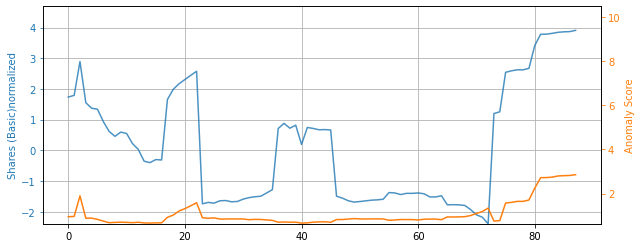

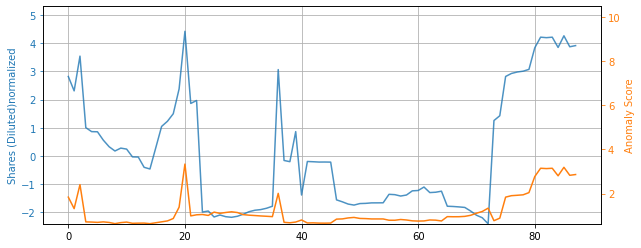

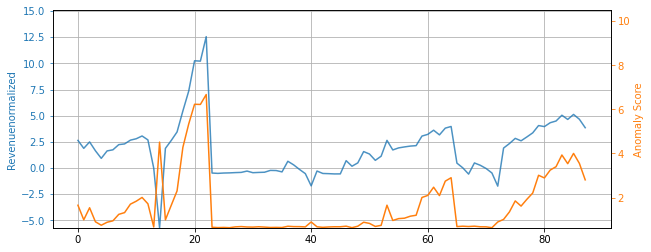

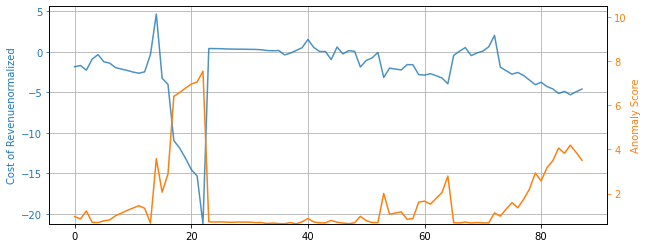

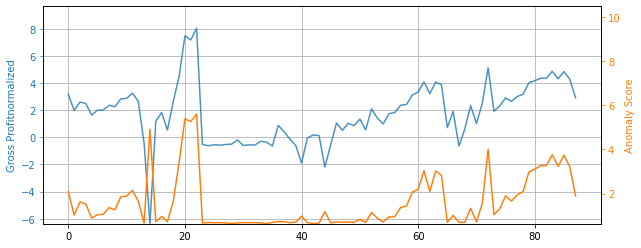

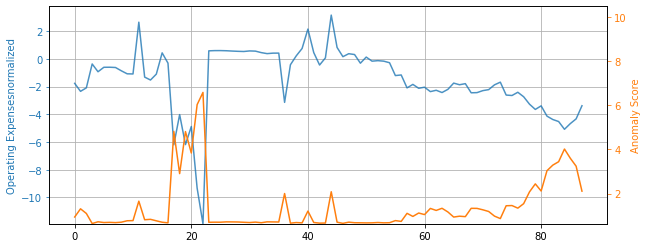

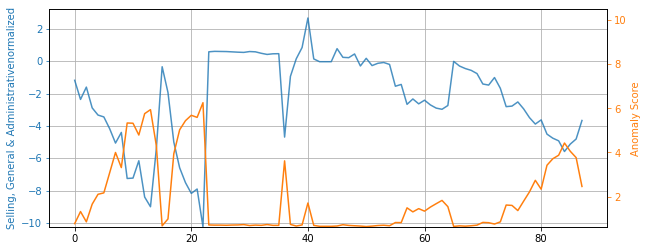

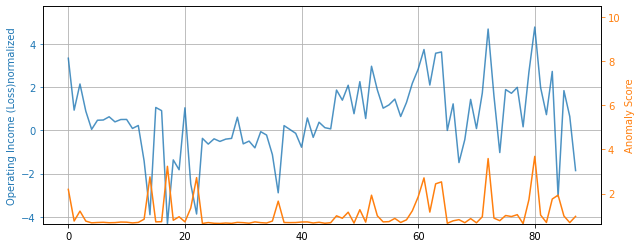

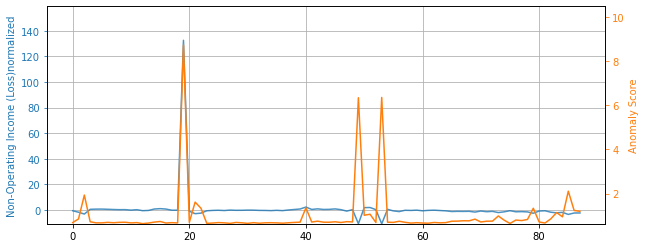

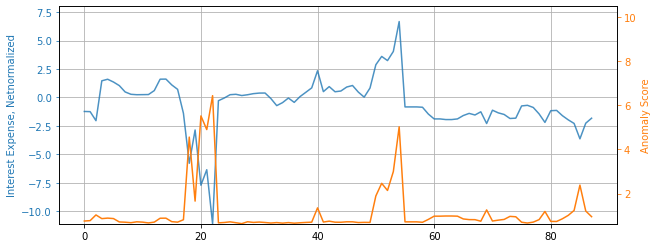

In [617]:
for i in range(len(colname)-1):
    plot_graph(i)

 It’s clear that for some data points of extreme large or small values, the corresponding anomaly scores are also high.  
